In [1]:
import pandas as pd
import numpy as np

def load_data():
    df = pd.read_csv('../data/MLParamData_1583906408.4261804_From_MLrn_2020-03-10+00_00_00_to_2020-03-11+00_00_00.h5_processed.csv.gz')
    df=df.replace([np.inf, -np.inf], np.nan)
    df=df.dropna(axis=0)
    return df

df = load_data()

In [134]:
import random, gym
from gym import spaces
from gym.utils import seeding

class emulator(gym.Env):
  def __init__(self,df):
    self.df = df
    
    self.min_BIMIN = 103
    self.max_BIMIN = 104
    self.max_IMINER = 1
    
    self.low_state = np.array(
      [self.min_BIMIN,-self.max_IMINER], dtype=np.float32
    )
    
    self.high_state = np.array(
      [self.max_BIMIN, self.max_IMINER], dtype=np.float32
    )
    
    self.observation_space = spaces.Box(
      low   = self.low_state, 
      high  = self.high_state, 
      dtype = np.float32
    )
    
    self.action_space = spaces.Box(
      low   = self.min_BIMIN,
      high  = self.max_BIMIN,
      shape = (1,),
      dtype = np.float32
    )
    
    self.reset(self.df)
    
  def seed(self, seed=None):
    self.np_random, seed = seeding.np_random(seed)
    return [seed]
      
  def predict(self,x):
    y=self._BIMINER_linear(x)
    r=self._random_from_cdf(x)
    return y+r
  
  def step(self,action):
    self.err = self.predict(action)
    self.done = bool(
     abs(self.err) >= self.max_IMINER # fail
    )
    
    self.reward = 0
    if self.done:
      self.reward = -10
    self.reward = -self.err
    
    self.state = np.array([action,self.err])
    return self.state, self.reward, self.done, {}
  
  def reset(self,df):
    self.seed()
    self.df = df
    self.df = self._prepData(self.df)
    init = self.np_random.uniform(low=self.min_BIMIN, high=self.max_BIMIN)
    print(init)
    self.err = self.predict(init)
    self.state = np.array([init, self.err])
    
  def _prepData(self,df):
    self.m, self.b = self._LinearRegression(df)
    df["IMINER_linear"]=self._BIMINER_linear(df["B:VIMIN"]) # the linear regression portion
    df["IMINER_std"]=df["B:IMINER"]-df["IMINER_linear"] # the noise portion
    return df
    
  def _LinearRegression(self,df):
    x_min = df["B:VIMIN"].min()
    x_max = df["B:VIMIN"].max()
    y_min = df[df["B:VIMIN"]==x_min]["B:IMINER"].max()
    y_max = df[df["B:VIMIN"]==x_max]["B:IMINER"].min()
    m=(y_min-y_max)/(x_min-x_max)
    b=y_min-m*x_min
    return m,b
  
  def _BIMINER_linear(self,x):
    y=self.m*x+self.b
    return y
  
  def _random_from_cdf(self,x):
    sampling_window = 0.005
    nbins = 100
    df = self.df
    
    #filter according to x-axis:
    y_std = df[df["B:VIMIN"].between(x-sampling_window,x+sampling_window)]
    
    # get the y-axis noise value according to the x-axis filtering
    hist, bins = np.histogram(y_std["IMINER_std"] , bins=nbins)
    bin_midpoints = bins[:-1] + np.diff(bins)/2
  
    cdf = np.cumsum(hist)
    cdf = cdf / cdf[-1]
  
    values = np.random.rand(len(y_std)*10)
    value_bins = np.searchsorted(cdf, values)
    random_from_cdf = bin_midpoints[value_bins]
  
    if len(random_from_cdf)>0:
      i=random.randint(0,len(random_from_cdf)-1)
      return random_from_cdf[i]
    else:
      return 0

env = emulator(df[0:5000])
print (env.state)
state, reward, done, info =env.step(103.0)
env.reset(df[1:5001])
#err_pred=env.step(103.3)
print(env.state)


103.05889173605635
[103.05889174   3.03393953]
103.47131173775702
[103.47131174  -0.75155385]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in true_divide


In [54]:
## emulator outputs
length=1000
y_pred=[]
X = df[0:length]["B:VIMIN"]
y = df[0:length]["B:IMINER"]
env = emulator(df[0:length])
for x in X:
  #print(x)
  output=env.predict(x)
  y_pred.append(output)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


-7.826082937289971 809.158780705037


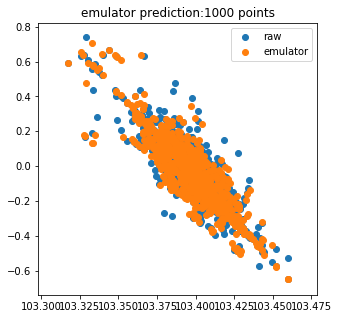

In [55]:
def plot_stat(X,y,y_pred):
  import matplotlib.pyplot as plt
  plt.rcParams["figure.figsize"] = (5,5)
  plt.scatter(X,y,label="raw")
  plt.scatter(X,y_pred,label="emulator")
  plt.title('emulator prediction:'+str(len(X))+' points')
  plt.legend()
  
plot_stat(X,y,y_pred)

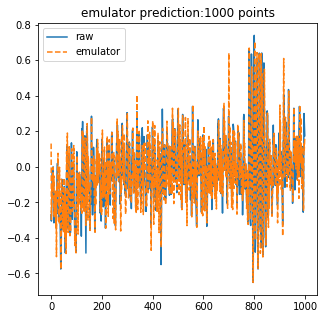

In [56]:
def plot_time(X,y,y_pred):
  plt.plot(y.tolist(),label='raw')
  plt.plot(y_pred,label='emulator',linestyle='dashed')
  plt.legend()
  plt.title('emulator prediction:'+str(len(X))+' points')
  
plot_time(X,y,y_pred)